**Problem**: 

I want to approximate the non-linear data space that makes up a PyPSA simulation. Specifically, I want to approximate a modified IEEE 13 bus topology with a uniform (grid) input. The approximation should be time sensitive.

**Objective**:

This notebook will only look at [support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) (SVR) models. Per [1], the approximation should have a root mean sqaure error < 0.002 to ensure the approximation is not the largest source of error in the simulation. A standard linear regression will be shown for baseline comparison. Since the approximation is time sensitive, a search for the ball park number of samples required for reasonable scores is performed. Once the number of samples to produce reasonable results is found, a grid search can be ran to determine optimal training parameters.

**Hypothesis**: 

Previously, linear regression models outperformed artificial neural networks when tested on simple, small radial networks [2]. Since the modified IEEE 13 bus network contains two transformers whos behaviour can become non-linear if their power limit is exceeded (which is allowed in power flow [3]), I suspect there are two possible scenarios:

1. Transformer limit not exceeded: Linear regression outperforms RF model
2. Transformer limit exceeded: RF outperforms linear regressor because a RF model can capture non-linearity 

As for the number of samples required, historically 1e5-1e6 samples produces K-fold cross validation scores with low variance if the feature-label correlation is reasonable.

**Experimental Procedure**:

1. Determine the number of samples required to return reasonable scores with SVR K-fold cross validation. Reasonable scores is defined as:
  * R2 > 0.8
  * RMSE < 0.002
  * K-fold R2 variance one degree of magnitude less than R2
2. Using approximately that number of samples, run grid search to determine optimal parameters/hyperparameters

**Results**:

The model was unable to predict the first label. This is expected because the node represented by the label is a slack bus and therefore its voltage is always 1. The results for the other labels were averaged

* 1e4 samples (mean R2: 0.88, std dev: 0.002)
* 1e3 samples (mean R2: 0.87, std dev: 0.014)
* 1e2 samples (mean R2: 0.79, std dev: 0.076)
* 1e1 samples (mean R2: -15, std dev: 19)

If the slack bus is removed the results improve by roughly 9%

* 1e4 samples (mean R2: 0.96, std dev: 0.002)
* 1e3 samples (mean R2: 0.95, std dev: 0.009)
* 1e2 samples (mean R2: 0.87, std dev: 0.069)
* 1e1 samples (mean R2: -16, std dev: 20)

From 1e3 to 1e4 samples there is not a significant improvement in mean R2 (1%), but there is in the std dev (). From 1e2 to 1e3 it is more apparent (9%). Running a grid search with 1e3 samples produced the following results:

1. Mean R2: ? std dev: ?
2. Mean R2: ? std dev: ?
3. .
4. .

Tried training the model on 1e5 samples for over 5 hours. Cancelled.

**Discussion**:

One approach to reduce the cost of simulation-based research is to copy the underlying model and evaluate the approximation [1][4].

It takes roughly 7 hours to create 1e5 samples (by running PyPSA sim) on Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz


**Bibliography**

[1] https://github.com/mbardwell/masters

[2] Enhancing Power Flow Simulations Using Function Mapping. Michael Bardwell ; Petr Musilek. 2019 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE)

[3] https://groups.google.com/forum/#!searchin/pypsa/mikey%7Csort:date/pypsa/FqfC_UR85k0/vBc7HYP_EQAJ

[4] ieee-13_timing-pfsim-vs-evaluating-models.ipynb


Table of Contents:
* Source data
* Analyse data
* Setup grid search

In [70]:
import copy
import csv
import importlib
import logging
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypsa
import seaborn as sns

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

In [82]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name + "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)


def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    import pandas as pd
    
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")


def set_uniform_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''

    Parameters
    ----------
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"] 
    '''

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
          
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                ## special cases
                if datatype == "generators-p_max_pu":
                    # add a ridiculous amount of generation so the is always enough power and sim doesn't fail
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=100, high=200, size=n_samples)
                elif datatype == "snapshots":
                    addon[column] = np.ones(n_samples)
                else:
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=0, high=0.5, size=n_samples)
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][0])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(1).append(addon_dataframe)

    for datatype in data:
        data[datatype] = increase_data(data[datatype], n_samples-1, seed) # -1 is for original sample, which stays
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))


def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    from pathlib import Path
    import shutil
    
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/"  # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_gaussian_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")


def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import errno
    import os
    import shutil

    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Backup was not successful. Directory not copied. Error: %s' % e)



def add_mean_and_std_rows(dataframe):
    mean = dataframe.mean()
    std = dataframe.std()
    dataframe.loc["mean"] = mean
    dataframe.loc["std"] = std
    return dataframe


def maxae(y, y_pred, **kwargs):
    import numpy as np
    return max(np.abs(y-y_pred).ravel())

def rmse(y, y_pred, **kwargs):
    import operator
    return np.sqrt(np.mean(np.square(list(map(operator.sub, y, y_pred)))))

def set_data_size(features, labels, n_samples, n_training_samples):
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val, train_idx, test_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)

    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val, test_idx, train_idx

def train_models_on_given_sample_size(regression_model, features, labels, n_samples_array=[100, 1000, 10000, 100000], prompt=True):
    """
    Trains regression model on a variety of sample sizes
    
    parameters
    ----------
    features: pandas DataFrame
    labels: pandas DataFrame
    n_sample_array: array
        ex: [100, 1000, 10000, 100000]
    regression_model: sklearn regressor
        ex: RandomForestRegressor
    """
    import datetime

    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import make_scorer, r2_score
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.model_selection import cross_validate, train_test_split
    from tabulate import tabulate
    
    if prompt == True:
        savefile_descriptor_addon = input("Add on extra descriptor to saved file (ex: -testing_maxae)? ")
    else:
        if isinstance(prompt, str):
            savefile_descriptor_addon = prompt
        else:
            print("Prompt not a string. Foregoing descriptor")
            savefile_descriptor_addon = ''
    linear = LinearRegression()
    common_cross_validate_variables = {"cv": 5,
                                       "n_jobs": -1,
                                       "scoring": {"r2": make_scorer(r2_score), 
                                                   "rmse": make_scorer(rmse),
                                                   "mae": make_scorer(mae),
                                                   "maxae": make_scorer(maxae)}}
    summary = {}

    for i, n_samples in enumerate(n_samples_array):
        current_iteration = i

        # do not split data into train/val; cross_validate will automatically do that
        samples_to_use = np.random.randint(0, features.shape[0], n_samples)
        X = features.iloc[samples_to_use].values
        y = labels.iloc[samples_to_use].values
        
        print("\n\nRun: ", current_iteration)
        print("n_samples for k fold cross validation: ", n_samples)
        print("n_features: ", X.shape[1])
        print("n_labels: ", y.shape[1])

        ## regression model to evaluate
        print("\n\n{} REGRESSION\n\n".format(regression_model_name.upper()))
        
        time_start = time.time()
        svr_models = []
        for label in range(y.shape[1]):
            svr_y = y.T[label].T
            svr_xval_scores = pd.DataFrame(cross_validate(regression_model, X, svr_y, 
                                                          **common_cross_validate_variables))
            svr_xval_scores.columns = [col + "_label_" + str(label) for col in svr_xval_scores.columns]
            if label == 0:
                regression_model_results = svr_xval_scores
            else:
                regression_model_results = regression_model_results.join(svr_xval_scores)

            svr_models.append(regression_model.fit(X, svr_y))
        time_regression_model = time.time()
        
        print("cross validation training time {:.5}".format(time_regression_model-time_start))
        print("cross validation training scores: ")
        regression_model_results.columns = [regression_model_name+"_"+col for col in regression_model_results.columns]
        regression_model_results = add_mean_and_std_rows(regression_model_results)
        display(regression_model_results)

#         print("non-cross validation model scores for reference:")
#         n_training_samples = int(n_samples*80/100)
#         X_train, y_train, X_val, y_val, _, _ = set_data_size(features, labels, n_samples, n_training_samples)
#         print("n_training_samples: ", n_training_samples)
#         print("n_validation_samples: ", n_samples-n_training_samples)
#         for label in range(y_train.shape[1]):
#             svr_y_train = y_train.T[label].T
#             svr_y_val = y_val.T[label].T
#             regression_model.fit(X_train, svr_y_train)
#             print("label: ", label)
#             print("training score: ", r2_score(svr_y_train, regression_model.predict(X_train)))
#             print("validation score: ", r2_score(svr_y_val, regression_model.predict(X_val)))
#             print("rmse: ", rmse(regression_model.predict(X_val), svr_y_val))



        ## linear regression for baseline comparison
        print("\n\nLINEAR REGRESSION\n\n")
        time_start = time.time()
        linear_results = pd.DataFrame(cross_validate(linear, X, y, **common_cross_validate_variables))
        time_linear = time.time()
        print("cross validation training time {:.5}".format(time_linear-time_start))
        print("cross validation training scores: ")
        linear_results.columns = ["linear_"+col for col in linear_results.columns]
        linear_results = add_mean_and_std_rows(linear_results)
        display(linear_results)

#         linear.fit(X_train, y_train)
#         print("non-cross validation model scores for reference:")
#         print("training score: ", r2_score(y_train, linear.predict(X_train)))
#         print("validation score: ", r2_score(y_val, linear.predict(X_val)))
#         print("rmse: ", rmse(linear.predict(X_val), y_val))



        ## save models
        datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
        results_to_save = regression_model_results.join(linear_results)
        results_to_save.to_csv(path_to_powerflow_data + 
                               "/results/approximating_with_{}_model_results-{}_samples-uniform_input-{}{}.csv".format(
                                   regression_model_name,
                                   n_samples, 
                                   datetimestamp,
                                   savefile_descriptor_addon))
        
        summary[n_samples] = results_to_save.loc["mean"].values

    summary = pd.DataFrame(summary, index=results_to_save.columns)
    summary_table = tabulate(summary, tablefmt="pipe", headers="keys")
    print("\n\nSUMMARY\n\n", summary_table)
    with open(path_to_powerflow_data + "/results/approximating_with_{}_model_summary-uniform_input-{}{}.txt".format(
                  regression_model_name,
                  datetimestamp,
                  savefile_descriptor_addon), "w") as f:
        f.write(summary_table)

# Source Data

In [72]:
## USER INPUT
sample_size = 100000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example + "/ieee-13-with-load-gen-uniform-data-" +
                          str(sample_size) + "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [73]:
## Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
# else:
#     create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

# Analyse Data

In [74]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1)
features_and_labels = features.join(labels)

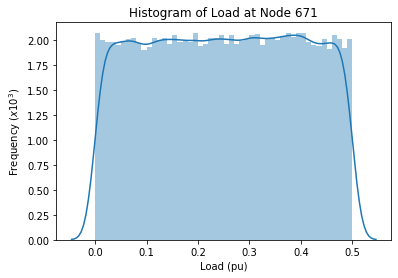

In [75]:
sns.distplot(features["load-671"], bins=50)
plt.xlabel("Load (pu)")
plt.ylabel("Frequency ($x10^3$)")
plt.title("Histogram of Load at Node 671")
# plt.savefig("uniform-samples-1e5-input-histogram.pdf")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c6ad2ab90>,
      dtype=object)

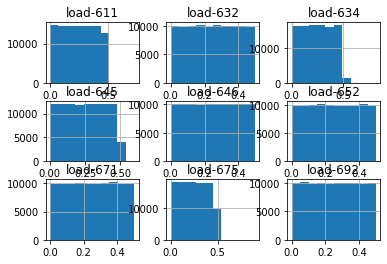

In [76]:
features.hist()

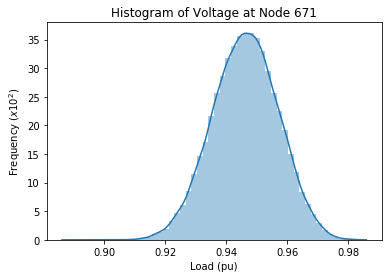

In [77]:
sns.distplot(labels["vmag-671"], bins=50)
plt.xlabel("Load (pu)")
plt.ylabel("Frequency ($x10^2$)")
plt.title("Histogram of Voltage at Node 671")
# plt.savefig("uniform-samples-1e5-voltage-histogram.pdf")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c6e3b55d0>,
      dtype=object)

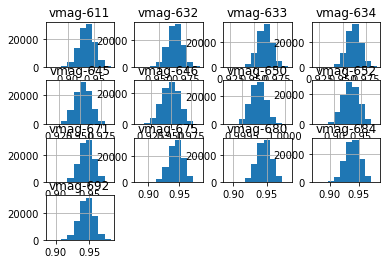

In [78]:
labels.hist()

In [79]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-650,-0.008439,0.001458,-0.002953,-0.000081,-0.001955,-0.007134,-0.001353,-0.004306,-0.001971,-0.002970
vmag-646,-0.196512,-0.200144,-0.487273,-0.671172,-0.211606,-0.204674,-0.199273,-0.208235,-0.211118,-0.287779
vmag-645,-0.219407,-0.223990,-0.546822,-0.558979,-0.235927,-0.229190,-0.223332,-0.233060,-0.236599,-0.300812
vmag-632,-0.316812,-0.320804,-0.319882,-0.333944,-0.339195,-0.329811,-0.324215,-0.334387,-0.339914,-0.328774
vmag-633,-0.286406,-0.512513,-0.289868,-0.302645,-0.307178,-0.298881,-0.292050,-0.303695,-0.307554,-0.322310
vmag-634,-0.286326,-0.512387,-0.289801,-0.302548,-0.307111,-0.298800,-0.291940,-0.303616,-0.307463,-0.322221
vmag-611,-0.157880,-0.158084,-0.155850,-0.168281,-0.463138,-0.316864,-0.313902,-0.320260,-0.600170,-0.294936
vmag-684,-0.170285,-0.171447,-0.168631,-0.182151,-0.502244,-0.343257,-0.340429,-0.346904,-0.501052,-0.302933
vmag-671,-0.196724,-0.199334,-0.196651,-0.210183,-0.410146,-0.399117,-0.395772,-0.403272,-0.410221,-0.313491
vmag-692,-0.196689,-0.199299,-0.196616,-0.210148,-0.410075,-0.399049,-0.395916,-0.403413,-0.410151,-0.313484


# Determine number of samples to get reasonable scores

In [80]:
# setup model parameters/hyperparameters

'''
dnn hyperparameters are chosen from sandbox testing. On average the model attempts to converge 
(with other parameters it sometimes gives up early).
'''
from sklearn.svm import SVR

regression_model = SVR(gamma='scale', C=1.0, epsilon=0.0002, kernel='rbf')

regression_model_name = "svr"

In [87]:

###########################CHANGE ME. TRAINING ON WITHOUT-VMAG650 DATA AND I COMMENTED OUT NON-CROSS VAL CODE IN FUNCTIONS


train_models_on_given_sample_size(regression_model, features, labels.T[1:].T, n_samples_array=[10000],
                                  prompt="-baseline")



Run:  0
n_samples for k fold cross validation:  10000
n_features:  9
n_labels:  12


SVR REGRESSION


cross validation training time 5027.5
cross validation training scores: 


,svr_fit_time_label_0,svr_score_time_label_0,svr_test_r2_label_0,svr_test_rmse_label_0,svr_test_mae_label_0,svr_test_maxae_label_0,svr_fit_time_label_1,svr_score_time_label_1,svr_test_r2_label_1,svr_test_rmse_label_1,...,svr_test_r2_label_10,svr_test_rmse_label_10,svr_test_mae_label_10,svr_test_maxae_label_10,svr_fit_time_label_11,svr_score_time_label_11,svr_test_r2_label_11,svr_test_rmse_label_11,svr_test_mae_label_11,svr_test_maxae_label_11
0,109.333510,2.662825,0.964902,0.001992,0.001542,0.008057,107.074411,2.608946,0.962191,0.001844,...,0.969799,0.002741,0.002134,0.010462,107.498308,2.637807,0.964891,0.002042,0.001570,0.008274
1,109.047863,2.681383,0.964645,0.002003,0.001549,0.011819,109.170588,2.684069,0.961320,0.001859,...,0.968548,0.002749,0.002142,0.010224,107.454996,2.674058,0.964313,0.002055,0.001590,0.008766
2,109.159171,2.641118,0.962737,0.002065,0.001581,0.008128,105.900203,2.601867,0.960095,0.001906,...,0.967500,0.002767,0.002129,0.011173,109.015753,2.715632,0.962184,0.002073,0.001591,0.009511
3,111.427834,2.690742,0.962160,0.002048,0.001577,0.007351,108.703164,2.643068,0.959431,0.001888,...,0.969036,0.002763,0.002135,0.010633,110.770565,2.704576,0.963214,0.002060,0.001581,0.010508
4,109.617177,2.732265,0.963115,0.002010,0.001557,0.009902,109.758493,2.663598,0.960264,0.001846,...,0.967137,0.002744,0.002094,0.012885,110.143787,2.707940,0.961054,0.002055,0.001567,0.009284
mean,109.717111,2.681666,0.963512,0.002024,0.001561,0.009051,108.121372,2.640309,0.960660,0.001868,...,0.968404,0.002753,0.002127,0.011075,108.976682,2.688003,0.963131,0.002057,0.001580,0.009269
std,0.980166,0.034065,0.001204,0.000031,0.000017,0.001811,1.592892,0.035094,0.001092,0.000027,...,0.001094,0.000011,0.000019,0.001070,1.506884,0.032209,0.001558,0.000011,0.000011,0.000842




LINEAR REGRESSION


cross validation training time 0.27098
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.034442,0.013550,0.981921,0.001442,0.001140,0.007260
1,0.007093,0.010247,0.980788,0.001482,0.001167,0.006818
2,0.005262,0.010064,0.980945,0.001464,0.001144,0.005933
3,0.005872,0.028387,0.980654,0.001478,0.001157,0.006700
4,0.006011,0.010175,0.980296,0.001451,0.001134,0.005984
mean,0.011736,0.014485,0.980921,0.001464,0.001148,0.006539
std,0.012710,0.007909,0.000608,0.000017,0.000013,0.000570




SUMMARY

 |                         |        10000 |
|:------------------------|-------------:|
| svr_fit_time_label_0    | 109.717      |
| svr_score_time_label_0  |   2.68167    |
| svr_test_r2_label_0     |   0.963512   |
| svr_test_rmse_label_0   |   0.0020237  |
| svr_test_mae_label_0    |   0.00156129 |
| svr_test_maxae_label_0  |   0.00905125 |
| svr_fit_time_label_1    | 108.121      |
| svr_score_time_label_1  |   2.64031    |
| svr_test_r2_label_1     |   0.96066    |
| svr_test_rmse_label_1   |   0.00186849 |
| svr_test_mae_label_1    |   0.00143917 |
| svr_test_maxae_label_1  |   0.00878029 |
| svr_fit_time_label_2    |  98.6108     |
| svr_score_time_label_2  |   2.52343    |
| svr_test_r2_label_2     |   0.952664   |
| svr_test_rmse_label_2   |   0.00140776 |
| svr_test_mae_label_2    |   0.00108088 |
| svr_test_maxae_label_2  |   0.00643116 |
| svr_fit_time_label_3    | 103.749      |
| svr_score_time_label_3  |   2.58569    |
| svr_test_r2_label_3     |   0.956571   |

In [91]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

sample_size = 100000
path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example + "/ieee-13-with-load-gen-uniform-data-" +
                          str(sample_size) + "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"


foo = pd.read_csv(path_to_powerflow_results + "approximating_with_svr_model_results-10000_samples-uniform_input-2019-09-23-19-03-baseline.csv")
display(foo.sort_values("svr_test_r2_label_1", ascending=False))

mean_and_std(foo, 1)

,Unnamed: 0,svr_fit_time_label_0,svr_score_time_label_0,svr_test_r2_label_0,svr_test_rmse_label_0,svr_test_mae_label_0,svr_test_maxae_label_0,svr_fit_time_label_1,svr_score_time_label_1,svr_test_r2_label_1,svr_test_rmse_label_1,svr_test_mae_label_1,svr_test_maxae_label_1,svr_fit_time_label_2,svr_score_time_label_2,svr_test_r2_label_2,svr_test_rmse_label_2,svr_test_mae_label_2,svr_test_maxae_label_2,svr_fit_time_label_3,svr_score_time_label_3,svr_test_r2_label_3,svr_test_rmse_label_3,svr_test_mae_label_3,svr_test_maxae_label_3,svr_fit_time_label_4,svr_score_time_label_4,svr_test_r2_label_4,svr_test_rmse_label_4,svr_test_mae_label_4,svr_test_maxae_label_4,svr_fit_time_label_5,svr_score_time_label_5,svr_test_r2_label_5,svr_test_rmse_label_5,svr_test_mae_label_5,svr_test_maxae_label_5,svr_fit_time_label_6,svr_score_time_label_6,svr_test_r2_label_6,svr_test_rmse_label_6,svr_test_mae_label_6,svr_test_maxae_label_6,svr_fit_time_label_7,svr_score_time_label_7,svr_test_r2_label_7,svr_test_rmse_label_7,svr_test_mae_label_7,svr_test_maxae_label_7,svr_fit_time_label_8,svr_score_time_label_8,svr_test_r2_label_8,svr_test_rmse_label_8,svr_test_mae_label_8,svr_test_maxae_label_8,svr_fit_time_label_9,svr_score_time_label_9,svr_test_r2_label_9,svr_test_rmse_label_9,svr_test_mae_label_9,svr_test_maxae_label_9,svr_fit_time_label_10,svr_score_time_label_10,svr_test_r2_label_10,svr_test_rmse_label_10,svr_test_mae_label_10,svr_test_maxae_label_10,svr_fit_time_label_11,svr_score_time_label_11,svr_test_r2_label_11,svr_test_rmse_label_11,svr_test_mae_label_11,svr_test_maxae_label_11,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0,109.333510,2.662825,0.964902,0.001992,0.001542,0.008057,107.074411,2.608946,0.962191,0.001844,0.001423,0.008406,95.829254,2.520977,0.954496,0.001393,0.001066,0.006545,103.720007,2.527869,0.957881,0.001477,0.001130,0.006508,104.365649,2.786781,0.957278,0.001489,0.001141,0.006547,108.130504,2.741767,0.968972,0.002451,0.001897,0.009801,109.782603,2.712881,0.967349,0.002314,0.001790,0.009243,107.958588,2.668800,0.964891,0.002042,0.001570,0.008274,109.892685,2.690636,0.964980,0.002039,0.001571,0.008562,110.450699,2.796437,0.966139,0.002102,0.001613,0.008548,107.470089,2.728578,0.969799,0.002741,0.002134,0.010462,107.498308,2.637807,0.964891,0.002042,0.001570,0.008274,0.034442,0.013550,0.981921,0.001442,0.001140,0.007260
1,1,109.047863,2.681383,0.964645,0.002003,0.001549,0.011819,109.170588,2.684069,0.961320,0.001859,0.001437,0.011643,97.710513,2.470994,0.953537,0.001404,0.001091,0.006802,103.764287,2.646520,0.956982,0.001486,0.001152,0.008609,105.007636,2.627828,0.955792,0.001507,0.001169,0.008704,107.985270,2.908646,0.967621,0.002488,0.001929,0.010048,107.837797,2.722763,0.966192,0.002338,0.001808,0.009433,108.075733,2.676829,0.964313,0.002055,0.001590,0.008766,108.543995,2.686126,0.964272,0.002057,0.001591,0.008901,109.222192,2.754979,0.965451,0.002121,0.001642,0.009083,104.551084,2.748811,0.968548,0.002749,0.002142,0.010224,107.454996,2.674058,0.964313,0.002055,0.001590,0.008766,0.007093,0.010247,0.980788,0.001482,0.001167,0.006818
5,mean,109.717111,2.681666,0.963512,0.002024,0.001561,0.009051,108.121372,2.640309,0.960660,0.001868,0.001439,0.008780,98.610762,2.523425,0.952664,0.001408,0.001081,0.006431,103.748743,2.585695,0.956571,0.001493,0.001145,0.007132,105.212328,2.638430,0.955511,0.001511,0.001160,0.007139,109.618758,2.839808,0.966952,0.002490,0.001915,0.010736,109.933633,2.762492,0.965371,0.002342,0.001799,0.010107,109.877481,2.719339,0.963145,0.002057,0.001580,0.009278,109.436363,2.705140,0.963152,0.002057,0.001580,0.009284,110.263208,2.797828,0.964400,0.002120,0.001628,0.009576,106.579332,2.785856,0.968404,0.002753,0.002127,0.011075,108.976682,2.688003,0.963131,0.002057,0.001580,0.009269,0.011736,0.014485,0.980921,0.001464,0.001148,0.006539
4,4,109.617177,2.732265,0.963115,0.002010,0.001557,0.009902,109.758493,2.663598,0.960264,0.001846,0.001431,0.008322,101.153937

r2 mean: 0.96181 std: 0.0013584 for labels from 1 to 12
rmse mean: 0.002014 std: 1.714e-05 for labels from 1 to 12
mae mean: 0.0015485 std: 1.3345e-05 for labels from 1 to 12
maxae mean: 0.0089824 std: 0.0009628 for labels from 1 to 12


In [90]:
def mean_and_std(results_dataframe, label_min):
    for score in ["r2", "rmse", "mae", "maxae"]:
        df_cols = [col for col in results_dataframe.columns if all(["svr" in col, 
                                                                    "test_" + score in col])]
        df = results_dataframe[df_cols[label_min:]].iloc[:-2]
        print("{} mean: {:.5} std: {:.5} for labels from {} to 12".format(score,
                                                                          df.mean().mean(), 
                                                                          df.std().mean(), 
                                                                          label_min))
    
path_1000 = (path_to_powerflow_data + "results/" + 
            "approximating_with_svr_model_results-1000_samples-uniform_input-2019-09-23-06-01-baseline.csv")
path_100 = (path_to_powerflow_data + "results/" + 
            "approximating_with_svr_model_results-100_samples-uniform_input-2019-09-23-06-01-baseline.csv")
path_10 = (path_to_powerflow_data + "results/" + 
            "approximating_with_svr_model_results-10_samples-uniform_input-2019-09-23-07-50-baseline.csv")


imported_results_1000 = pd.read_csv(path_1000)
mean_and_std(imported_results_1000, 0)

imported_results_100 = pd.read_csv(path_100)
mean_and_std(imported_results_100, 0)

imported_results_10 = pd.read_csv(path_10)
mean_and_std(imported_results_10, 0)

mean_and_std(imported_results_1000, 1)

mean_and_std(imported_results_100, 1)

mean_and_std(imported_results_10, 1)

r2 mean: 0.88051 std: 0.0060509 for labels from 0 to 12
rmse mean: 0.002046 std: 0.00012623 for labels from 0 to 12
mae mean: 0.0016065 std: 9.4948e-05 for labels from 0 to 12
maxae mean: 0.0069269 std: 0.0016442 for labels from 0 to 12
r2 mean: 0.74419 std: 0.078414 for labels from 0 to 12
rmse mean: 0.0035579 std: 0.00086151 for labels from 0 to 12
mae mean: 0.0026778 std: 0.00056914 for labels from 0 to 12
maxae mean: 0.0093129 std: 0.0028105 for labels from 0 to 12
r2 mean: -64.933 std: 107.15 for labels from 0 to 12
rmse mean: 0.011371 std: 0.0045449 for labels from 0 to 12
mae mean: 0.010481 std: 0.0043705 for labels from 0 to 12
maxae mean: 0.014204 std: 0.00598 for labels from 0 to 12
r2 mean: 0.95604 std: 0.005126 for labels from 1 to 12
rmse mean: 0.002209 std: 0.00013637 for labels from 1 to 12
mae mean: 0.0017344 std: 0.00010261 for labels from 1 to 12
maxae mean: 0.0074828 std: 0.0017795 for labels from 1 to 12
r2 mean: 0.82162 std: 0.065416 for labels from 1 to 12
rmse me

In [69]:
def results_layout(df, label_min, n_samples):
    fit_time_cols = [col for col in df.columns if all(["svr" in col, "fit_time" in col])]
    fit_time = df[fit_time_cols[label_min:]].iloc[:-2].mean().mean()
    
    score_time_cols = [col for col in df.columns if all(["svr" in col, "score_time" in col])]
    score_time = df[score_time_cols[label_min:]].iloc[:-2].mean().mean()
    
    print("\n\n{}".format(n_samples))
    print("fit_time: ", fit_time)
    print("score_time: ", score_time)
    
    for score in ["r2", "rmse", "mae", "maxae"]:
        df_cols = [col for col in df.columns if all(["svr" in col, 
                                                                    "test_" + score in col])]
        df_sh = df[df_cols[label_min:]].iloc[:-2]
        print("{} mean: {:.5} std: {:.5} for labels from {} to 12".format(score,
                                                                          df_sh.mean().mean(), 
                                                                          df_sh.std().mean(), 
                                                                          label_min))



    
results_layout(imported_results_1000, 0, 1000)
results_layout(imported_results_100, 0, 100)
results_layout(imported_results_10, 0, 10)
results_layout(imported_results_1000, 1, 1000)
results_layout(imported_results_100, 1, 100)
results_layout(imported_results_10, 1, 10)



1000
fit_time:  0.12674384117126464
score_time:  0.02900050970224234
r2 mean: 0.88051 std: 0.0060509 for labels from 0 to 12
rmse mean: 0.002046 std: 0.00012623 for labels from 0 to 12
mae mean: 0.0016065 std: 9.4948e-05 for labels from 0 to 12
maxae mean: 0.0069269 std: 0.0016442 for labels from 0 to 12


100
fit_time:  0.001435694327721229
score_time:  0.0018211951622596153
r2 mean: 0.74419 std: 0.078414 for labels from 0 to 12
rmse mean: 0.0035579 std: 0.00086151 for labels from 0 to 12
mae mean: 0.0026778 std: 0.00056914 for labels from 0 to 12
maxae mean: 0.0093129 std: 0.0028105 for labels from 0 to 12


10
fit_time:  0.0006095262674184946
score_time:  0.0014806674076960635
r2 mean: -64.933 std: 107.15 for labels from 0 to 12
rmse mean: 0.011371 std: 0.0045449 for labels from 0 to 12
mae mean: 0.010481 std: 0.0043705 for labels from 0 to 12
maxae mean: 0.014204 std: 0.00598 for labels from 0 to 12


1000
fit_time:  0.13723856210708618
score_time:  0.03130823771158854
r2 mean: 0

# Try different feature/label preprocessing techniques

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import Normalizer

# # test normalizing labels
# estimators = [("normalise", Normalizer()),
#               ('regression', regression_model)]
# preprocessed_model = Pipeline(estimators)
# train_models_on_given_sample_size(preprocessed_model, features, labels, n_samples_array=[10000],
#                                   prompt="-normalise")

In [ ]:
# # test outlier removal
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_error as mae
# from sklearn.pipeline import Pipeline

# def find_outliers(df, m=3):
#     """
#     Thanks https://stackoverflow.com/questions/21448225/getting-indices-of-true-values-in-a-boolean-list
#     """
#     from itertools import compress
    
#     import numpy as np
    
#     outliers = []
#     for col in df:
#         data = df[col]
#         positions = abs(data - np.mean(data)) > m * np.std(df[col])
#         outliers.append(list(compress(range(len(positions.values)), positions.values)))
    
#     flat_list = np.unique([item for sublist in outliers for item in sublist])
#     return flat_list

# def test_find_outliers():
#     import pandas as pd
#     y_train = pd.DataFrame([[1,2,3,4,5],
#                             [2,3,4,5,6],
#                             [3,4,5,6,7]])
#     return list(find_outliers(y_train, m=1)) == [0, 2] and list(find_outliers(y_train, m=2)) == []

# if not test_find_outliers():
#     assert(False)

# X_train, y_train, X_test, y_test, _, _ = set_data_size(features, labels, 100000, 80000)

# for sigma in [1,2,3,4,5]:
#     # find outliers in labels (voltages). If there is an outlier at any node remove the sample from the data set 
#     outliers = find_outliers(pd.DataFrame(y_train), m=sigma)

#     outlier_free_X_train = np.array([e for i, e in enumerate(X_train) if i not in outliers])
#     outlier_free_y_train = np.array([e for i, e in enumerate(y_train) if i not in outliers])

#     estimators = [('regression', regression_model)]
#     preprocessed_model = Pipeline(estimators)
#     preprocessed_model.fit(outlier_free_X_train, outlier_free_y_train)
#     print("\n\nScores with outliers removed by {}-sigma filter: ".format(sigma))
#     print("r2 score: {}".format(preprocessed_model.score(X_test, y_test)))
#     print("rmse score: {}".format(rmse(preprocessed_model.predict(X_test), y_test)))
#     print("mae score: {}".format(mae(preprocessed_model.predict(X_test), y_test)))
#     print("maxae score: {}".format(maxae(preprocessed_model.predict(X_test), y_test)))
    
#     samples_to_use = np.random.randint(0, np.array(X_train).shape[0], outlier_free_X_train.shape[0])
#     X_train_same_number_samples_as_outlier_free = pd.DataFrame(X_train).iloc[samples_to_use].values
#     y_train_same_number_samples_as_outlier_free = pd.DataFrame(y_train).iloc[samples_to_use].values

#     estimators = [('regression', regression_model)]
#     preprocessed_model = Pipeline(estimators)
#     preprocessed_model.fit(X_train_same_number_samples_as_outlier_free, y_train_same_number_samples_as_outlier_free)
#     print("\n\nScores with all data (incl. outliers): ".format(sigma))
#     print("r2 score: {}".format(preprocessed_model.score(X_test, y_test)))
#     print("rmse score: {}".format(rmse(preprocessed_model.predict(X_test), y_test)))
#     print("mae score: {}".format(mae(preprocessed_model.predict(X_test), y_test)))
#     print("maxae score: {}".format(maxae(preprocessed_model.predict(X_test), y_test)))

In [ ]:
# # test dimensionality reduction
# from sklearn.pipeline import Pipeline

# # first determine how many features to drop
# import eli5
# X_train, y_train, X_test, y_test, _, _ = set_data_size(features, labels, 1000, 800)
# regression_model = RandomForestRegressor(n_estimators=100, max_depth=None)
# regression_model.fit(X_train, y_train)
# perm = eli5.sklearn.PermutationImportance(regression_model, random_state=1).fit(X_train, y_train)
# display(eli5.show_weights(perm))


# # drop features using pca. Centre number of features around perm importance results, which is 3 features
# from sklearn.decomposition import PCA

# for n_features in [6,7,8]:
#     estimators = [("pca", PCA()),
#                   ('regression', regression_model)]
#     preprocessed_model = Pipeline(estimators)
#     preprocessed_model.set_params(pca__n_components=n_features)
#     train_models_on_given_sample_size(preprocessed_model, features, labels, n_samples_array=[100000],
#                                       prompt="-pca_{}_features".format(n_features))

In [ ]:
# # drop labels with poor correlation by not including them in the data set
# from sklearn.pipeline import Pipeline

# attributes = list(labels.keys())
# attributes.remove("vmag-650")
# labels_reduced = labels[attributes]

# estimators = [('regression', regression_model)]
# preprocessed_model = Pipeline(estimators)
# train_models_on_given_sample_size(preprocessed_model, features, labels_reduced, 
#                                   n_samples_array=[100, 1000, 10000, 100000], prompt="-without_vmag650")